## Phenotype waterfall plot

In [8]:
library(tidyverse) #include ggplot2
library(ComplexHeatmap)

source("utiles.R")


In [9]:

markers =  c('CD8','CK','CD20', 'CD4', 'FOXP3',  'CD68', 'CD11c', 'CD56',  'Unidentified' )


In [13]:

data_wide = read.csv("./data/waterfall/waterfall_compostion_by_MVB_wide.csv")


In [14]:
data_wide_sorted = data_wide %>%
                  mutate(CaseType = factor(CaseType, levels=c("Pleural", "Peritoneal")))%>%
                  mutate(subtype = factor(subtype, levels = c("epithelioid", "biphasic", "sarcomatoid"))) %>%
                  group_by(CaseType,subtype)  %>% # groupby will sort group by its factor level
                  arrange(desc(CD8), .by_group = TRUE)


In [15]:

data_long = data_wide_sorted  %>%
            replace(is.na(.), 0)  %>% #replce null to 0
             pivot_longer(2:10, names_to="Phenotype", values_to="Percent") %>% # select pivot columns to pivot
             mutate( MVB= factor(MVB, levels=data_wide_sorted$MVB))%>% # when plot, the order will change, so need to make it factor to keep the original order when plot
             mutate( Phenotype = factor(Phenotype, 
                                        levels=markers))

In [16]:
colors = setNames(  
                  sapply(markers, get_marker_color),
                  markers)


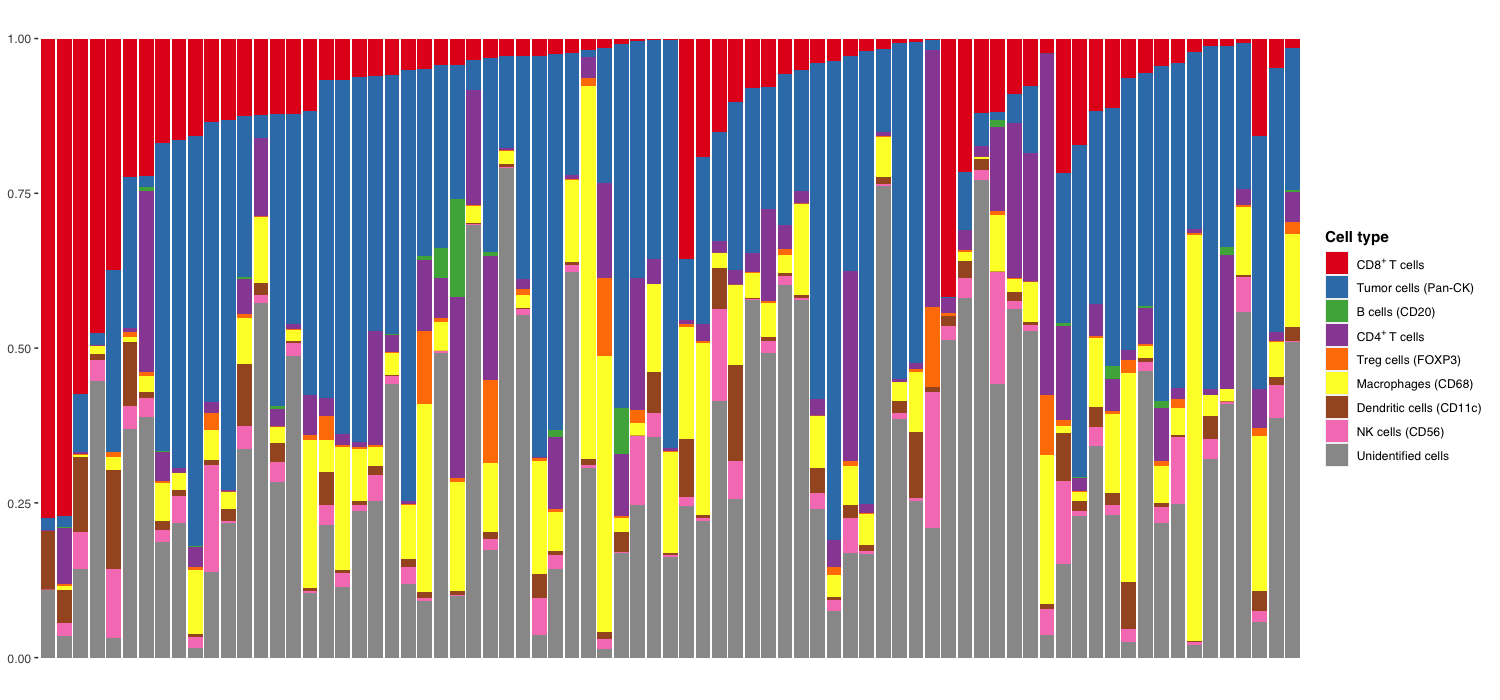

In [18]:
options(repr.plot.width =15, repr.plot.height = 7, repr.plot.res = 100)

my_labs = as.vector(sapply(markers, get_marker_label))
g1 = ggplot(data_long) +
  geom_bar(mapping =  aes( x=MVB,y=Percent, fill=Phenotype), 
    position="stack", stat="identity") + 
  # scale_fill_viridis(discrete=TRUE,option = "D", begin = 0, end = 1,direction = -1, name="") +
  # theme_ipsum() +
  theme(axis.title.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(), 
        panel.grid.major.x = element_blank(),
        legend.text.align=0,
        legend.title = element_text(face = "bold") ,
        panel.background = element_blank(), # remove backgroud
        text=element_text(family="sans")
  )+
  
  #left aligh legend
  scale_fill_manual(values = colors, #change the legend color and labels
                    labels=my_labs,
                    name="Cell type") +
  labs(x = "Patient", y= "Cell type composition")
  
  
 
print(g1)

In [ ]:
png(file=paste0(pathout, "waterfall_main_anno.png"), width=8.39,height=3.25,units="in",res=600, family="Arial")
print(ht)
dev.off()

## Bubble plot

In [20]:

library(data.table)
library(tidyr)
library(dplyr)
library(ggplot2)
library(gridExtra)
# library(viridis)
library(ggpubr)
library(ggtext)


In [21]:
grouptype = ".percent"
pathout3 = paste0("./data/Phenotype/DotPlot_Clinic_wilcox/")

df_dotplot = as.data.frame(fread(paste0(pathout3, "df_dotplot",grouptype,".csv")))
df_counts = as.data.frame(fread(paste0(pathout3, "df_category_counts.csv")))


In [22]:

orders = c("Grade", "Asbestos exposure",  "Smoking" , "Gender","Race", "Age split" )
df_dotplot$pvalues = as.numeric(df_dotplot$pvalues)
df_dotplot$diffs = as.numeric(df_dotplot$diffs)
df_dotplot$sep = factor(as.integer(df_dotplot$diffs > 0), levels= c(1,0))
df_dotplot$items = factor(df_dotplot$items, levels = rev(orders))
# df_dotplot$phenotypes = factor(df_dotplot$phenotypes, levels = rev(sort(df_plot$phenotypes)) )
df_dotplot$combine = paste0(df_dotplot$items, df_dotplot$sep)

df_dotplot$sig = 0
df_dotplot$sig[df_dotplot$pvalues < 0.05] = 1
df_dotplot$sig[df_dotplot$pvalues < 0.01] = 2
df_dotplot$sig[df_dotplot$pvalues < 0.001] = 3



In [23]:

orders = c("Grade", "Asbestos exposure",  "Smoking" , "Gender","Race", "Age split" )
markers = c("CD4", "CD8", "CK", "CD20", "CD68", "FOXP3", "CD11c", "CD56")
colors = c("Grade1", "Asbestos exposure1",  "Smoking1" , "Gender1","Race1", "Age split1", "Grade0", "Asbestos exposure0",  "Smoking0" , "Gender0","Race0", "Age split0"  )
genes = c("BAP1", "NF2", "MTAP", "LAG3")

df_dotplot$items = factor(df_dotplot$items, levels = rev(orders))
df_dotplot$combine = factor(df_dotplot$combine, levels = colors)

df_dotplot1 = df_dotplot[df_dotplot$phenotypes %in% markers,]
df_dotplot2 = df_dotplot[df_dotplot$phenotypes %in% genes,]

df_dotplot1$phenotypes = factor(df_dotplot1$phenotypes, levels = markers)
df_dotplot2$phenotypes = factor(df_dotplot2$phenotypes, levels = genes)



In [24]:

my_labs <- c( expression(CD4^{"+"}~'T cells'), expression(CD8^{"+"}~'T cells'),'Tumor cells (Pan-CK)','B cells (CD20)',
             'Macrophages (CD68)', 'Treg cells (FOXP3)','Dendritic cells (CD11c)', 'NK cells (CD56)')
scale_color = scale_color_manual(labels = c(
  paste0("High (n=",df_counts[df_counts$catgys=='Grade','Ng1'], ')'),
  paste0("Exposure (n=",df_counts[df_counts$catgys=='AsbestosExposure','Ng1'], ')'),
  paste0("Smoker (n=",df_counts[df_counts$catgys=='smoking','Ng1'], ')'),
  paste0("Male (n=",df_counts[df_counts$catgys=='Gender','Ng1'], ')'),
  paste0("White (n=",df_counts[df_counts$catgys=='Race','Ng1'], ')'),
  paste0("<=60 years of age (n=",df_counts[df_counts$catgys=='agesplit','Ng1'], ')'),
  
  paste0("Median/Low (n=",df_counts[df_counts$catgys=='Grade','Ng2'], ')'),
  paste0("not Exposure (n=",df_counts[df_counts$catgys=='AsbestosExposure','Ng2'], ')'),
  paste0("Non-smoker (n=",df_counts[df_counts$catgys=='smoking','Ng2'], ')'),
  paste0("Female (n=",df_counts[df_counts$catgys=='Gender','Ng2'], ')'),
  paste0("not White (n=",df_counts[df_counts$catgys=='Race','Ng2'], ')'),
  paste0(">60 years of age (n=",df_counts[df_counts$catgys=='agesplit','Ng2'], ')')
), 
                                 
  
values = c(Grade1 =  "#4E79A7",
           'Asbestos exposure1' ="#F28E2B",
           Smoking1 ="#59A14F",
           Gender1 = "#B6992D",
           Race1 = "#499894",
           'Age split1' = "#E15759",
           
           Grade0 = "#A0CBE8",
           'Asbestos exposure0' = "#FFBE7D",
           Smoking0 = "#8CD17D",
           Gender0 = "#F1CE63",
           Race0 = "#86BCB6",
           'Age split0' = "#FF9D9A"))    
                                       

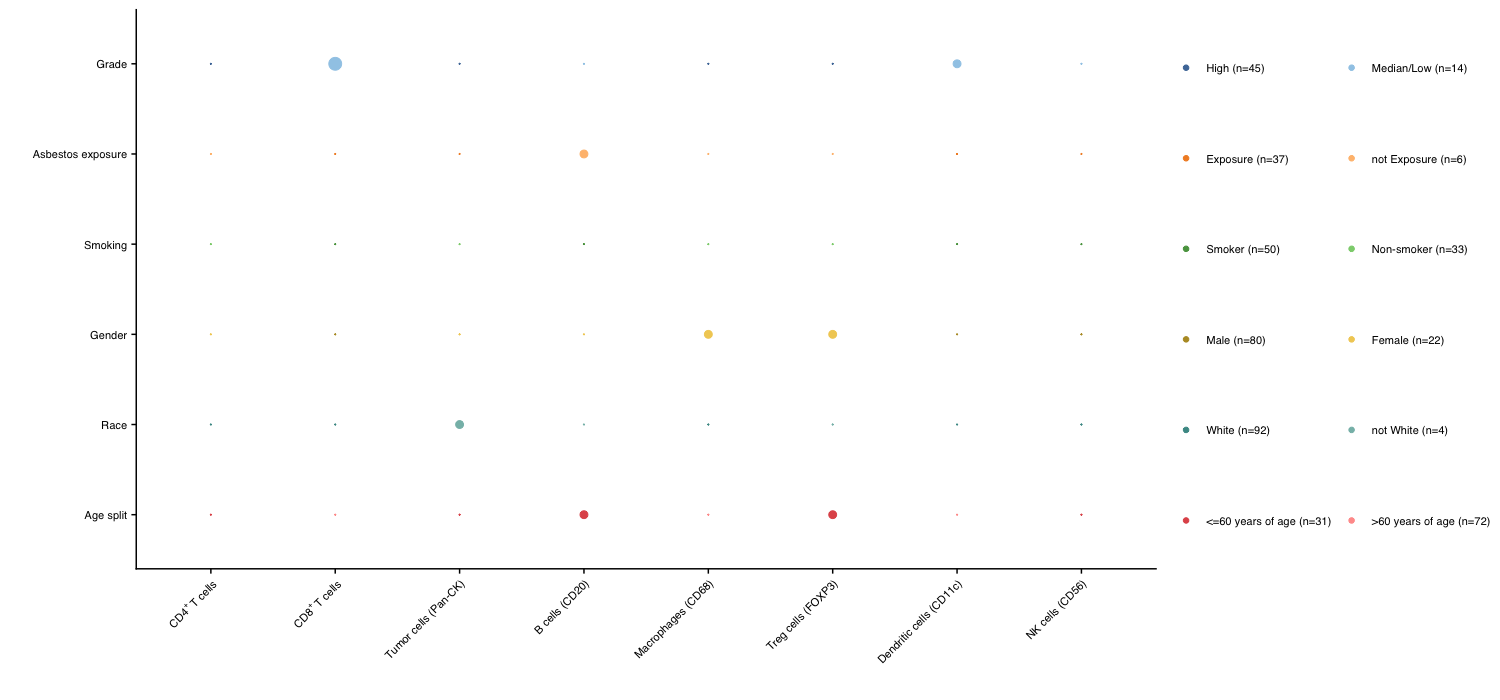

In [30]:
fig = df_dotplot1 %>% 
  ggplot(aes(x=phenotypes, y = items, size=sig , color=combine) )+ 
  geom_point() + 
  cowplot::theme_cowplot() + 
  # theme(axis.line  = element_blank()) +
  theme(axis.text.x = element_text(angle = 45, hjust=1, size=8)) +
  theme(axis.text.y = element_text(size=8)) +
  xlab('') +
  ylab('') +
  
  scale_x_discrete(labels = my_labs) +
  scale_size(range = c(0, 4), labels=c("not significant", "P < 0.05", "P < 0.01", "P < 0.001"), name="Pvalue") +
  
  scale_color +
  guides( colour = guide_legend(ncol=2)) + # change the lengend order
  theme(legend.text=element_text(size=8),
        legend.title=element_blank()) +
  theme(legend.key.height=unit(2.3,'cm')) +
  theme(text=element_text(family="sans")) +

  # guides(color = FALSE)
  guides(size = FALSE)


print(fig)

# Cell contact score heatmap

In [42]:
library(stats)
library(data.table)
library(tidyverse)


integration_type = "mean"
df_core_feature = read.csv(paste0("./output/cellContact/core_features_allMarkers_withIntensity_MVB_",integration_type, ".csv"), check.names = TRUE)


markers_all = c("CD4", "CD8", "CK", "CD20", "FOXP3", "CD68", "CD11c", "CD56", "BAP1", "NF2", "MTAP", "LAG3")
for (marker in markers_all){
  df_core_feature[,paste0(marker,".density")] = log(df_core_feature[,paste0(marker,".density")]  + .Machine$double.eps)
}

grouptype = ".percent" 


# pathout = paste0("./output/figure/by_patient/", integration_type, "/phenotype/Pleural_vs_Peritoneal/")
pathout = "../../Paper/Figure/NEW_ORGANIZATION/Phenotype/MPM_vs_MPeM/"

markers = c("CD4", "CD8", "CK", "CD20", "FOXP3", "CD68", "CD11c", "CD56")

df_core_feature = df_core_feature[df_core_feature$casetype != "Other",]

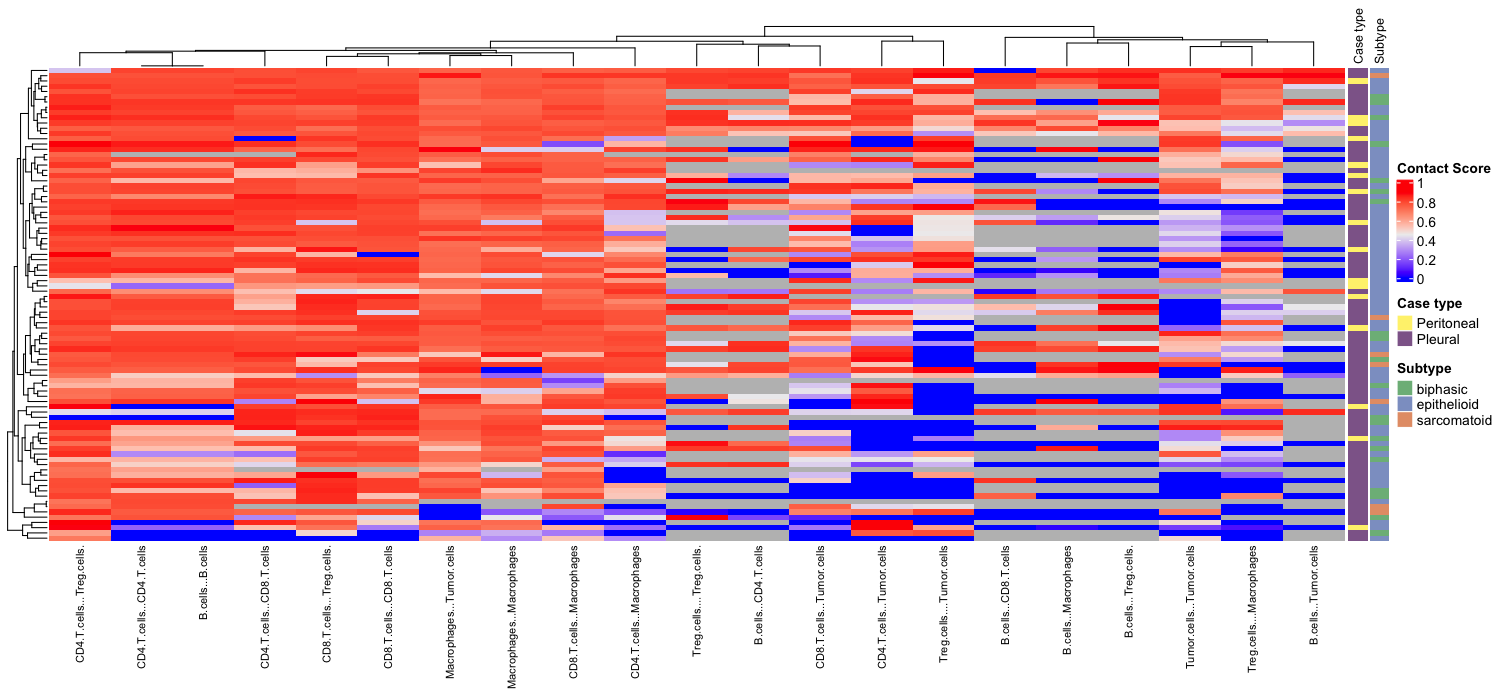

In [75]:
###################################################################
# draw heatmap
library(ComplexHeatmap)
library(tidyverse)


library(stats)
library(data.table)
library(tidyverse)
# library(stringr) #str_to_title 
source("utiles.R")



df_contacts = read.csv("./data/CellContact/Heatmap/cellContact_All_region.csv", row.names=1)

df_contacts_MVB = df_contacts %>% group_by(MVB,casetype,subtype) %>% summarise_all("mean",na.rm = TRUE) %>% as.data.frame()
df_contacts_MVB = filter(df_contacts_MVB, casetype != "Other")
df_contacts_MVB = filter(df_contacts_MVB, subtype %in% c("epithelioid", "biphasic", "sarcomatoid" ))

# normalize
df_contacts_MVB[,4:24] = min_max_normalize(df_contacts_MVB[,5:24], na.rm = TRUE)
# head(df_contacts_MVB)

data_heatmap  = df_contacts_MVB %>%
  column_to_rownames(var="MVB")  %>%
  select(-c(casetype,subtype))


ha = rowAnnotation(  "Case type" =df_contacts_MVB$casetype, 
                     Subtype = df_contacts_MVB$subtype,
                     col = list(
                       "Case type" = c("Pleural" = "#8f6798", "Peritoneal" = "#fef17c"),
                       Subtype = c("epithelioid" = "#8da0cb", "biphasic" = "#7db988", "sarcomatoid" = "#e59d76")
                     ),
                     
                     annotation_name_side = "top",
                     annotation_name_gp= gpar(fontsize = 9)
                     
)


ht = Heatmap (as.matrix(data_heatmap),
              right_annotation = ha,
              cluster_rows  = TRUE,
              cluster_columns = TRUE,
              show_heatmap_legend = T,
              show_row_names=F,
              heatmap_legend_param = list(
                title = "Contact Score"
              ),
              column_names_gp = grid::gpar(fontsize = 8),
              row_names_gp = grid::gpar(fontsize = 8)
              
)
ht


## MPM vs MPeM for CK ~ immune cell contacts 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 104 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 104 rows containing missing values (`geom_point()`).”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 53 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 53 rows containing missing values (`geom_point()`).”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


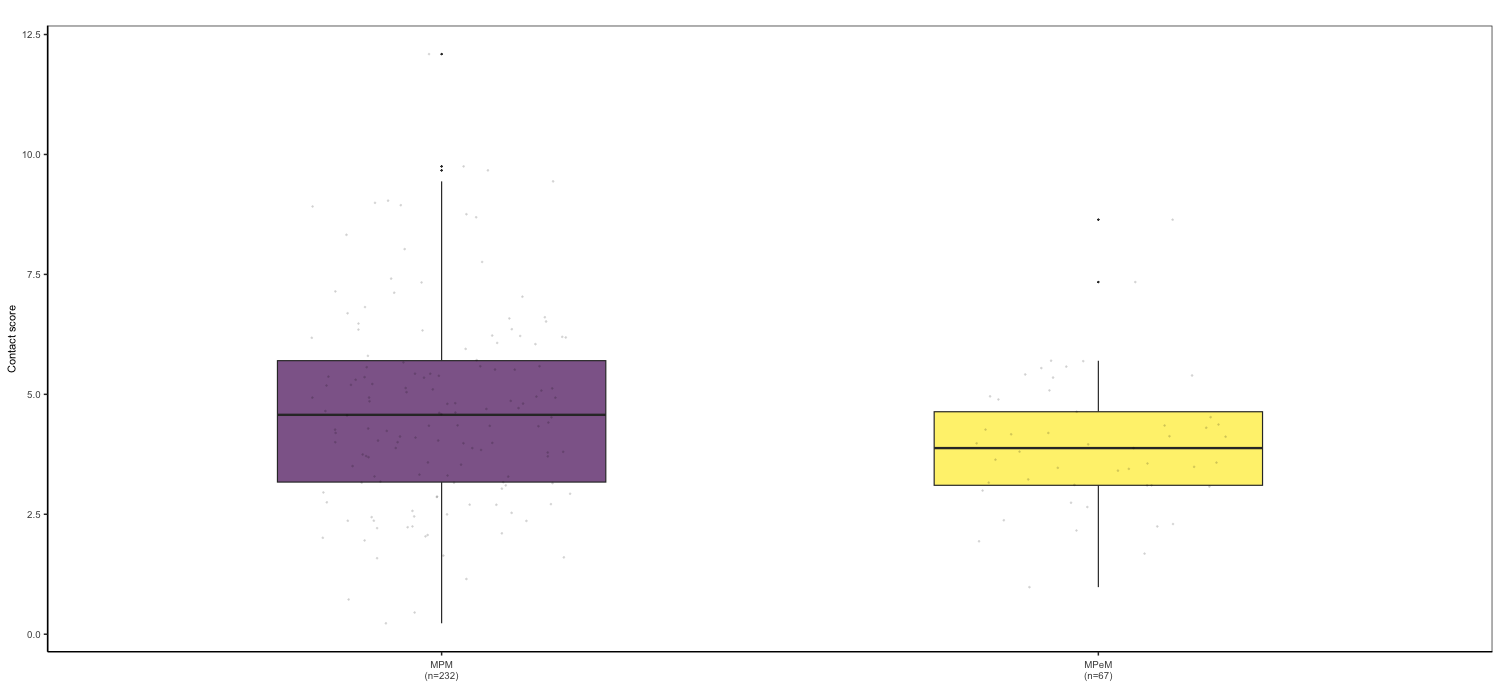

Warning message:
“Removed 58 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 58 rows containing missing values (`geom_point()`).”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


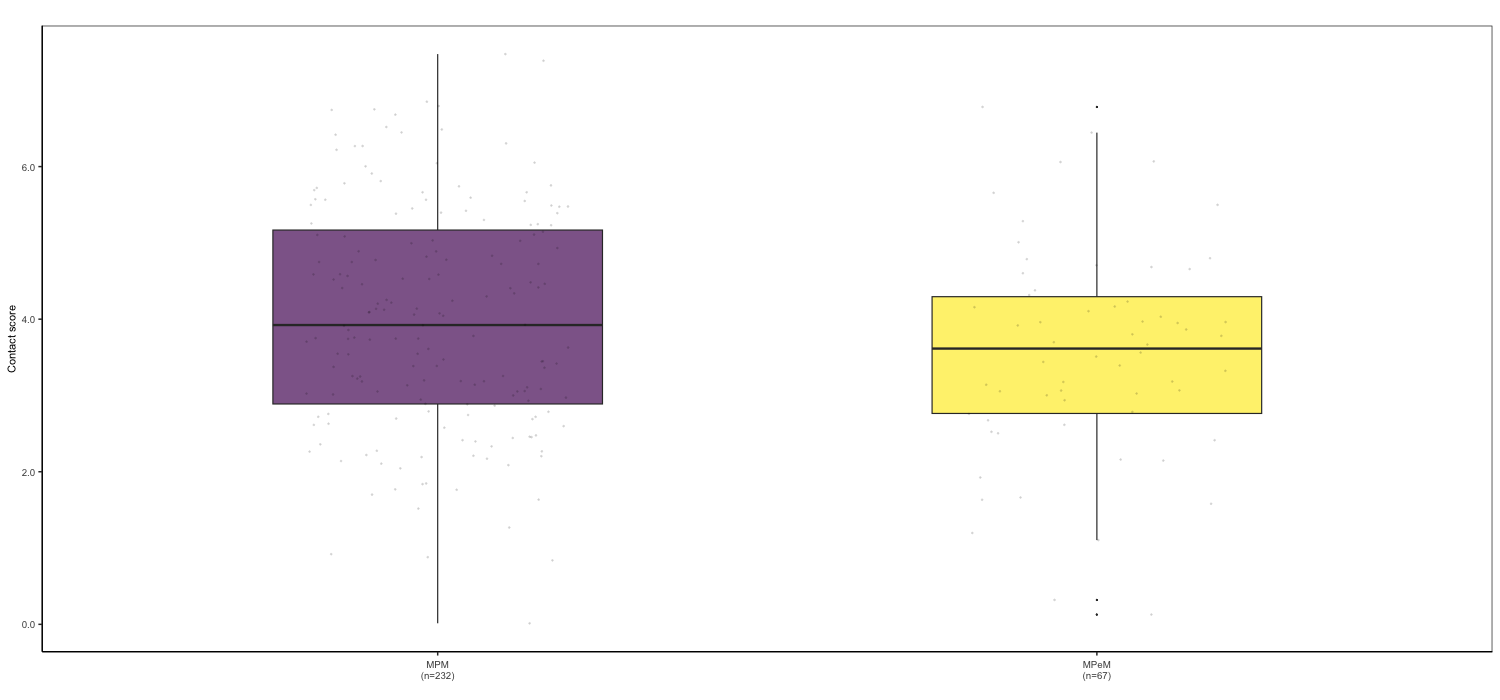

Warning message:
“Removed 208 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 208 rows containing missing values (`geom_point()`).”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


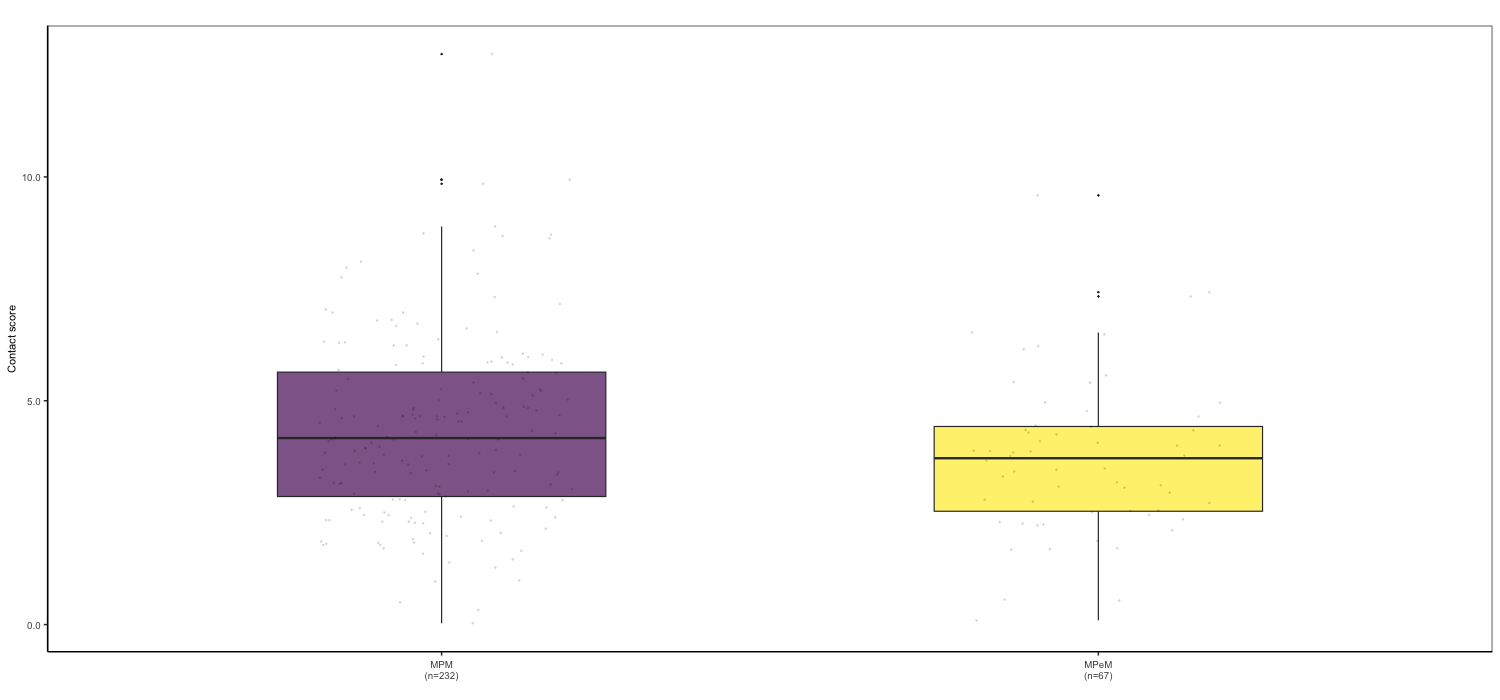

Warning message:
“Removed 259 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 259 rows containing missing values (`geom_point()`).”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


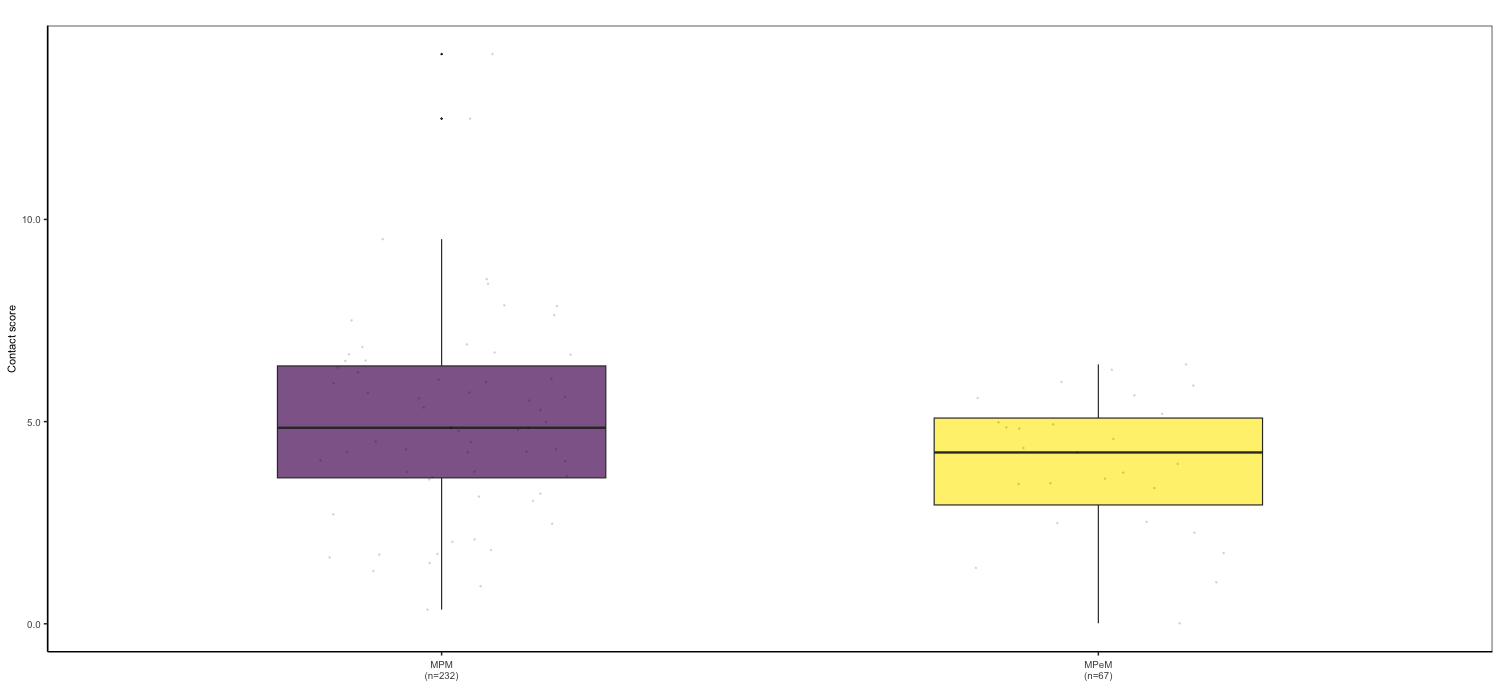

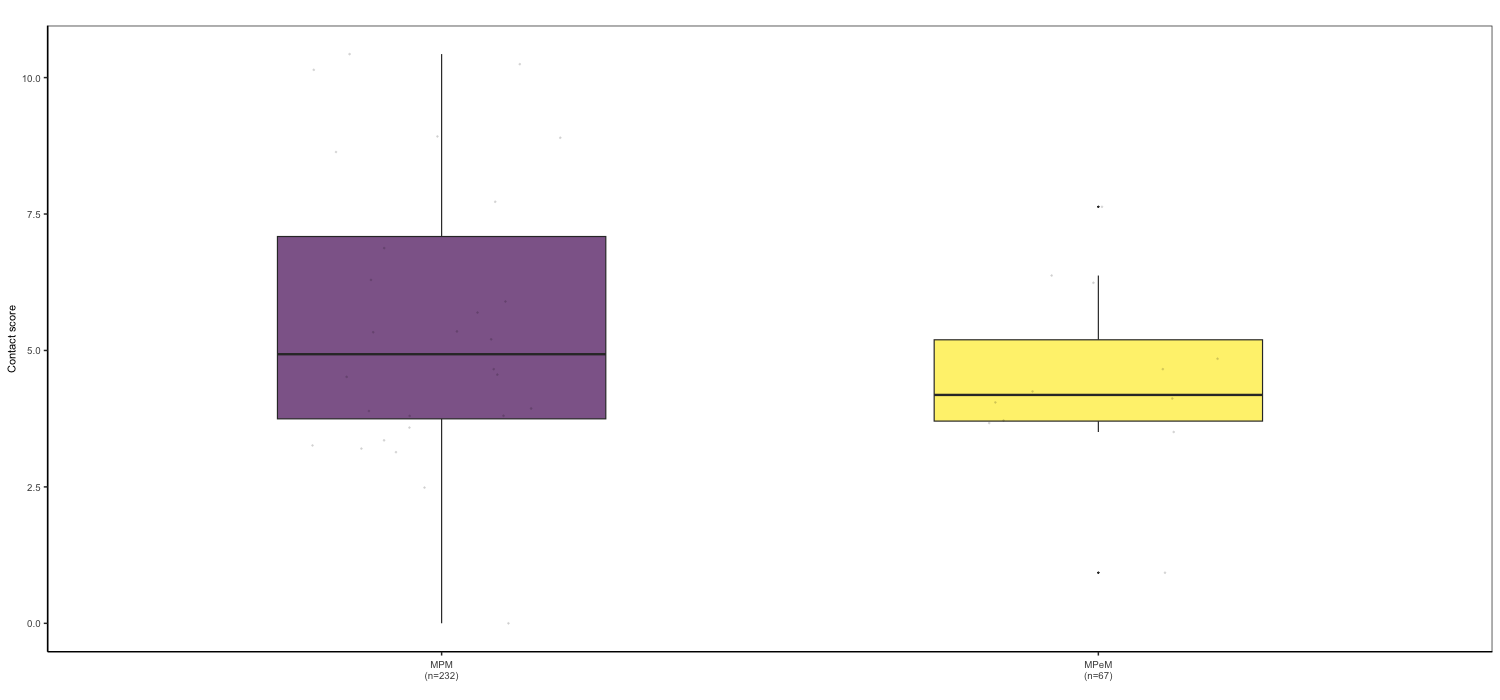

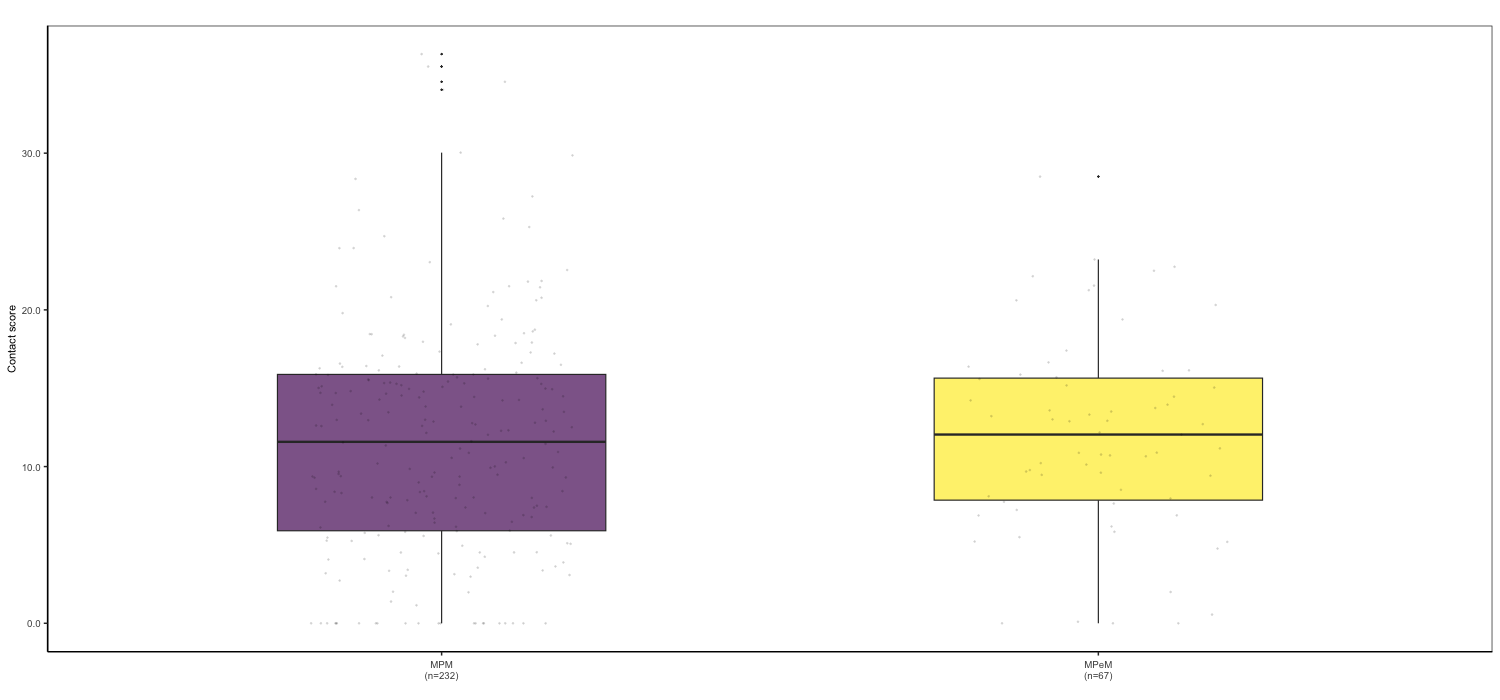

In [96]:

library(stats)
library(data.table)
library(tidyr)
library(stringr) #str_to_title 
library(dplyr)

source("utiles.R")

# save the df_contacts 
df_contacts = read.csv("./data/CellContact/MPM_vs_MPeM/Immune cell ~ CK contacts.csv", row.names=1, check.names=F)


CK_immune_contacts = c("CD4~CK", "CD8~CK", "CD68~CK", "FOXP3~CK", "CD20~CK")  #,

df_contacts$'CK~Immune cell' = rowSums(df_contacts[,CK_immune_contacts], na.rm=T)  #
#
#
# pl_contacts = df_contacts[df_contacts$casetype == "Pleural", "CK~Immune cell"]
# pe_contacts = df_contacts[df_contacts$casetype == "Peritoneal", "CK~Immune cell"]

pvalues = list()
for (contact in c(CK_immune_contacts,  "CK~Immune cell")){  #

  pl_contacts = df_contacts[df_contacts$casetype == "Pleural", contact]
  pe_contacts = df_contacts[df_contacts$casetype == "Peritoneal", contact]

  if (median(pl_contacts, na.rm=T) > median(pe_contacts, na.rm=T) ){
    alter = "greater"
  }else{
    alter = "less"
  }

  # pvalue = t.test(pl_contacts, pe_contacts, alternative = alter )$p.value
  pvalue = wilcox.test(pl_contacts, pe_contacts, alternative = alter )$p.value

  pvalue_f =  formatC(pvalue, format = "e", digits = 2)

  pvalues[[contact]] = pvalue_f

  if (median(pl_contacts, na.rm=T) > median(pe_contacts, na.rm=T) ){
    alter = "greater"
  }else{
    alter = "less"
  }

  # pvalue = t.test(pl_contacts, pe_contacts, alternative = alter )$p.value
  pvalue = wilcox.test(pl_contacts, pe_contacts, alternative = alter )$p.value

  pvalue_f =  formatC(pvalue, format = "e", digits = 2)

  casetype = c(rep("Pleural", length(pl_contacts)), rep("Peritoneal", length(pe_contacts)))
  contact_score = c(pl_contacts, pe_contacts)

  df_plot = cbind.data.frame(casetype, contact_score)
  singleboxplot_contactScore_plVSpe_noClinic(df_plot, 'contact_score', pl_contacts, pe_contacts, pvalue_f, pathout, contact, ypos=0.95, save=F)

}

## BAP1 high vs. low RIDGE plot

In [31]:
library(stats)
library(data.table)
library(tidyr)
library(stringr) #str_to_title 

library(dplyr)

In [40]:
df_feature = read.csv(paste0("./data/CellContact/BAP1_high_vs_low/CD8_CK_Tumore_scores.csv"), check.names=F)

In [41]:

P2marker = "BAP1"
measure = paste0(P2marker, " density")

cond_high = df_feature[,measure] > quantile(df_feature[,measure], 0.6, na.rm=T)
cond_low = df_feature[,measure] <= quantile(df_feature[,measure], 0.4, na.rm=T)

score_h = df_feature$pair_score[cond_high]
score_l = df_feature$pair_score[cond_low]

score_h = score_h[! is.na(score_h)]
score_l = score_l[! is.na(score_l)]

if (length(score_h)==0 | length(score_l)==0){
  pvalue=NA
}else{
  median_h = median(score_h, na.rm=TRUE)
  median_l = median(score_l, na.rm=TRUE)
  if (median_h > median_l){
    alter = "greater"
  }else{
    alter = "less"
  }
  pvalue = wilcox.test(score_h, score_l, alternative = alter)$p.value
  pvalue = formatC(pvalue, format = "e", digits = 2)
}



Picking joint bandwidth of 0.38

Warning message:
“Removed 2 rows containing non-finite values (`stat_density_ridges()`).”


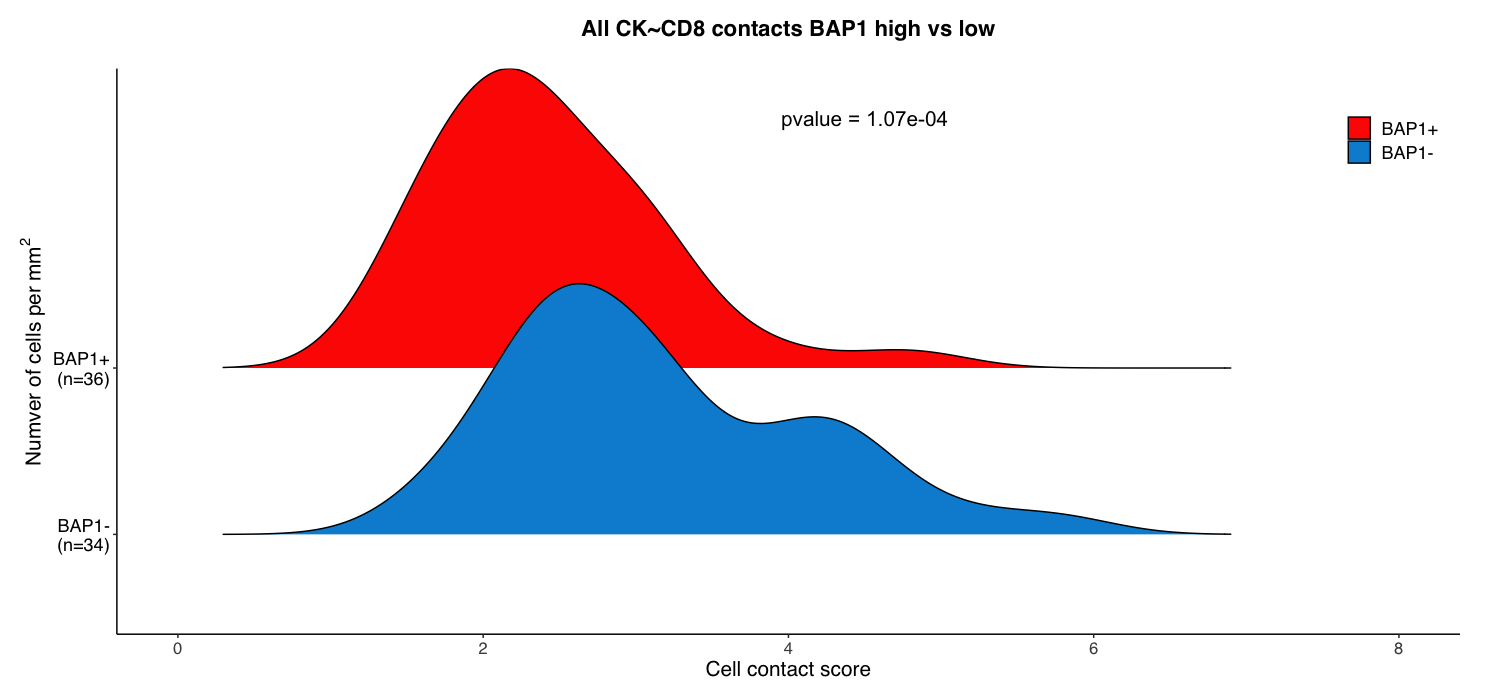

In [42]:

num_high = length(score_h)
num_low = length(score_l)

pair_score = c(score_h, score_l)
group = c(rep("BAP1+", length(score_h)), rep("BAP1-", length(score_l)))

df_plot = as.data.frame(cbind(pair_score, group))
df_plot$pair_score = as.numeric(df_plot$pair_score)
# df_plot$group = factor(df_plot$group, levels = c("BAP1+", "BAP1-")) #change the plot order

title = paste0(str_to_title(casetype), " CK~", ptype1, " contacts BAP1 high vs low") 


if (casetype=="all") xlim = c(0,8)
if (casetype== "Pleural") xlim = c(0,8)
if (casetype=="Peritoneal") xlim = c(1,6)

ridge_plot_BAP1(df_plot,title, "pair_score", "group", xlim, pvalue, num_high, num_low, pathout, save=FALSE )
  


## Similarity

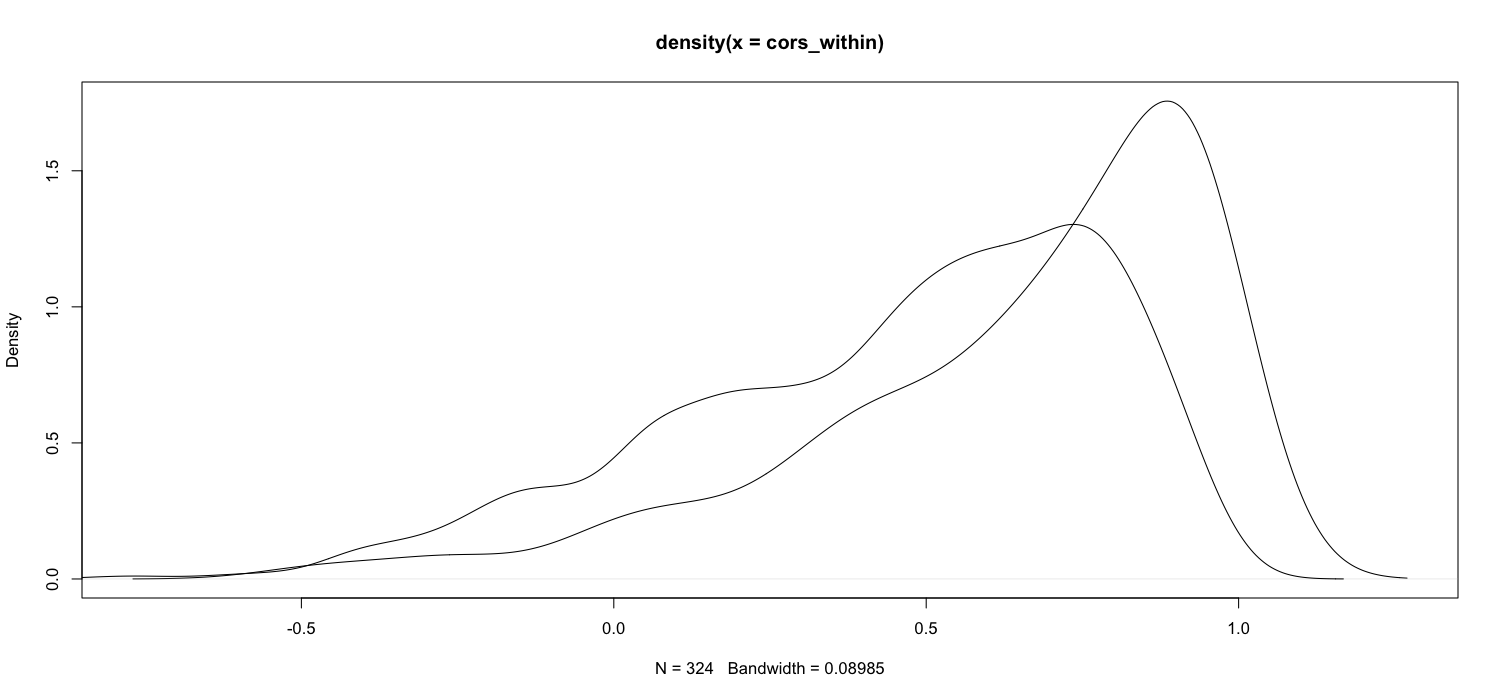

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


ERROR: Error in eval(expr, envir, enclos): object 'pathout' not found


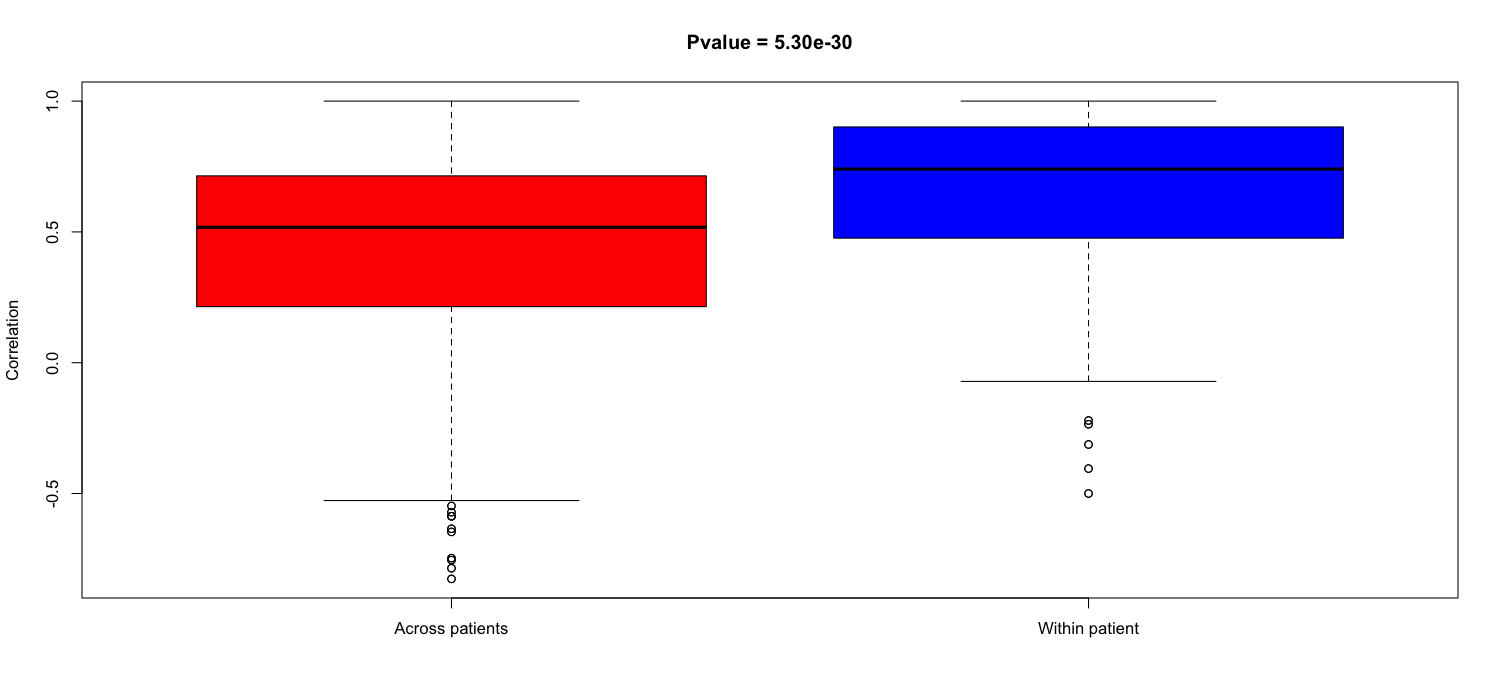

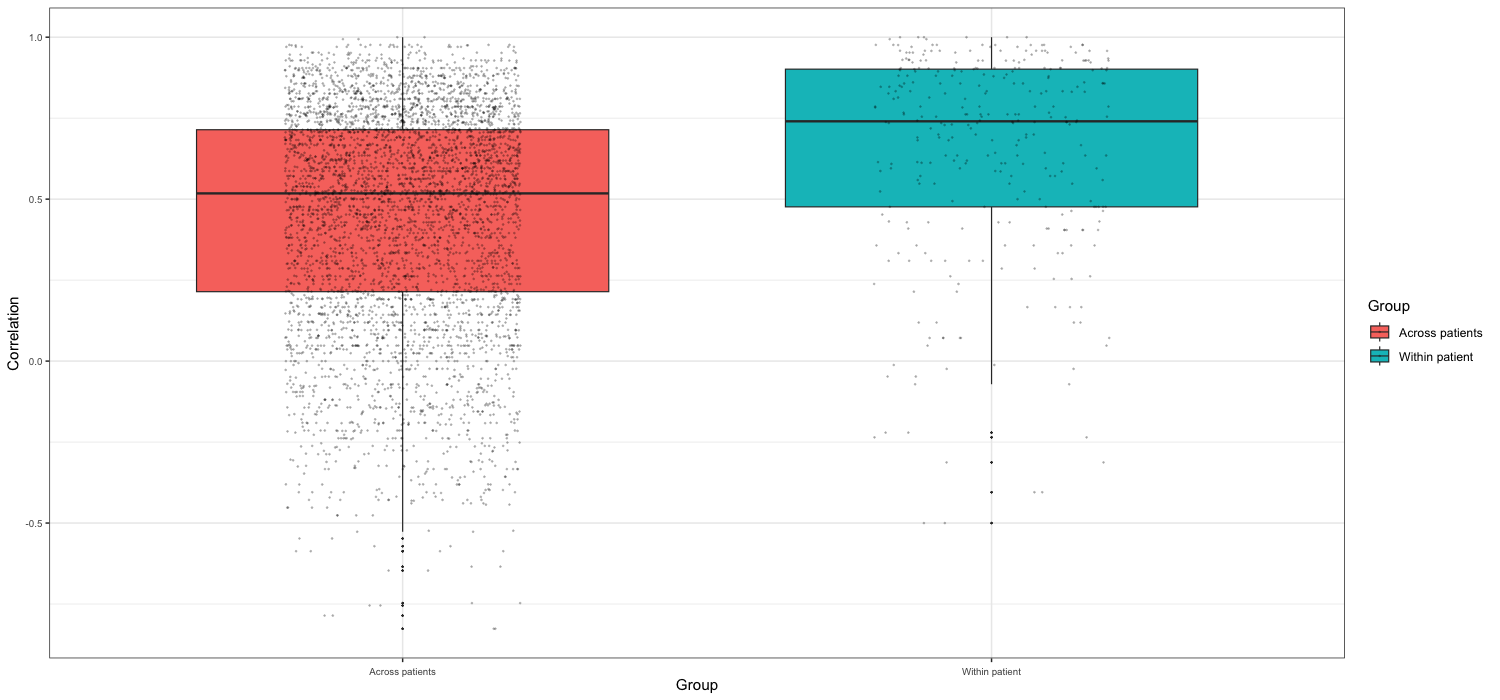

In [78]:

library(stats)
library(data.table)
# library(tidyr)
library(tidyverse)

source("utiles.R")


df_features = as.data.frame(fread("./data/TMA_data/core_features_allMarkers_withIntensity_core.csv", check.names = F))
df_features = df_features %>% column_to_rownames(var = "core ID" )

MVB_table = table(df_features$MVB)

ncores = 3
MVB_sub = names(MVB_table[MVB_table>ncores])

df_features_sub = df_features[(df_features$MVB %in% MVB_sub),]

markers1 = c('FOXP3', 'CD4', 'CD8', 'CD68', 'CD20', 'CK', 'CD11c', 'CD56')

grouptype = " density" #" percent"
cols_sel = paste0(markers1, grouptype)
df_plt = log(df_features_sub[,cols_sel]) + .Machine$double.eps
df_plt[,"MVB"] = df_features_sub[,'MVB']


# use correlation to compare
cors_within = c()
for (mvb in unique(df_plt$MVB)){
  df_mvb = df_plt[df_plt$MVB == mvb,]
  df_corr = t(df_mvb[, paste0(markers1 = c('FOXP3', 'CD4', 'CD8', 'CD68', 'CD20', 'CK', 'CD11c', 'CD56'),grouptype)])
  corMtx = cor(df_corr, method="spearman")
  for (row in rownames(corMtx)){
    for (col in colnames(corMtx)){
      if (row != col){
        cors_within = c(cors_within, corMtx[row, col]) 
      }
    }
  }
  # cors_within = c(cors_within, c(corMtx))
}

cor_within = median(cors_within)

# to calculate among, first calculate all then select among
df_corr_all = t(df_plt[, paste0(markers1 = c('FOXP3', 'CD4', 'CD8', 'CD68', 'CD20', 'CK', 'CD11c', 'CD56'),grouptype)])
# colnames(df_corr_all) = df_plt$MVB
corMtx_all = cor(df_corr_all, method="spearman")
cors_among = c()
for (row in rownames(corMtx_all)){
  for (col in colnames(corMtx_all)){
    row_MVB = df_plt[row, 'MVB']
    col_MVB = df_plt[col, 'MVB']
    if (row_MVB != col_MVB){
      cors_among = c(cors_among, corMtx_all[row, col])
    }
  }
}

cor_among = median(cors_among)

library(stats)
pvalue = wilcox.test(cors_within, cors_among)$p.value
pvalue = formatC(pvalue, format = "e", digits = 2)

# densitiy plot

plot(density(cors_within))
lines(density(cors_among))

cors = c(cors_within, cors_among)
group = factor(c( rep("Within patient", length(cors_within)), rep("Across patients", length(cors_among))), levels=c("Within patient", "Across patients"))
group = c( rep("Within patient", length(cors_within)), rep("Across patients", length(cors_among)))

data = as.data.frame(cbind(cors, group))
colnames(data) = c("Correlation", "Group")
data$Correlation = as.numeric(data$Correlation)
boxplot(Correlation ~ Group, data = data, col=c("red", "blue"), main=paste0("Pvalue = ", pvalue), xlab="")

title = paste0("similarity_within_vs_across_patient_", ncores)  # pateints have more than ncores cores
box_plot_similarity(data, 'Group', 'Correlation', pvalue, title, pathout)




## Phenotype association

ERROR: Error in eval(expr, envir, enclos): object 'outpath' not found


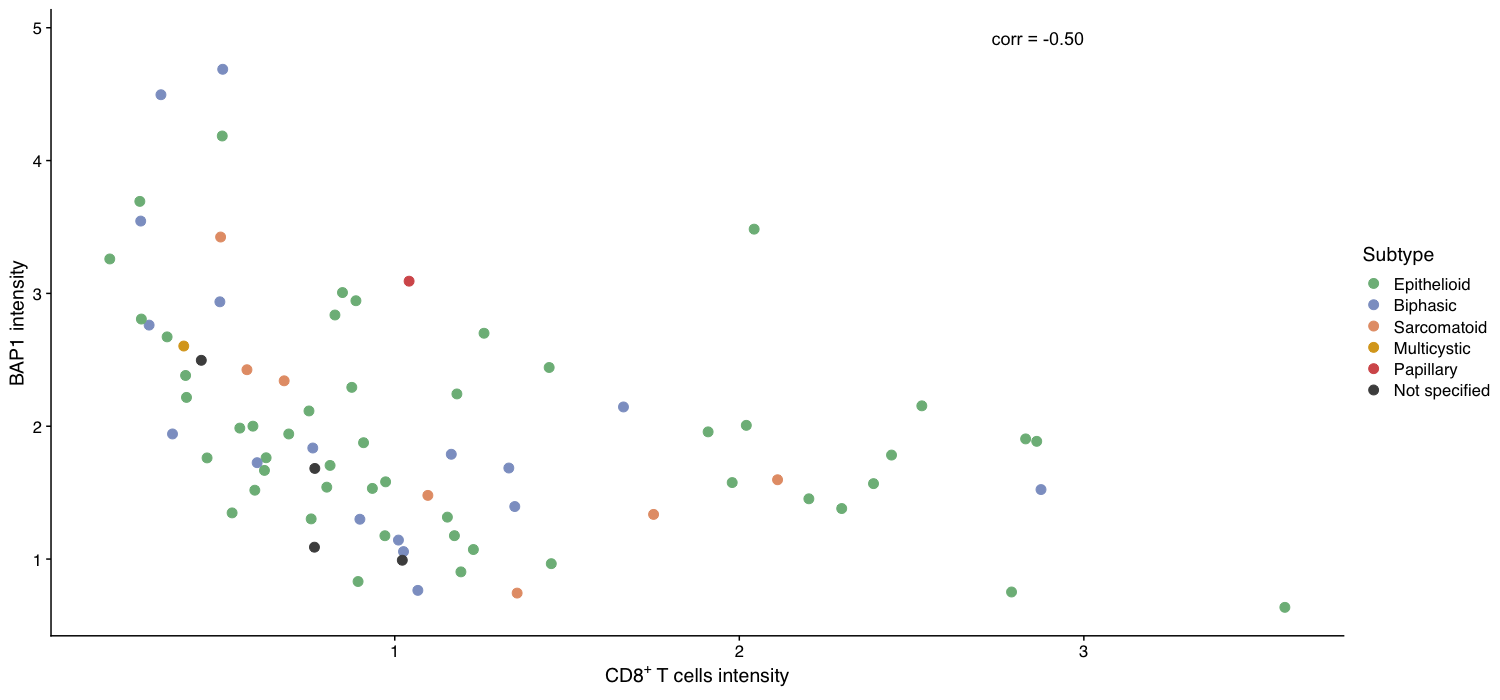

In [84]:
 library(data.table)
  library(tidyverse)
  
  
  source("utiles.R")
  
  df_feature_MVB = read.csv("./data/TMA_data/core_features_allMarkers_withIntensity_MVB_mean.csv")
  
  df_feature_MVB = mutate(df_feature_MVB, subtype=str_replace_all(subtype,  c("Not Specified" = "Not specified")))
  # or use
  #df_feature_MVB$subtype = gsub("Not Specified", "Not specified", df_feature_MVB$subtype)
  
  # df_feature_MVB =  filter(df_feature_MVB, subtype %in% c("biphasic", "epithelioid", "sarcomatoid"))
  
  grouptype = ".intensity"
  
  genes= c("BAP1", "NF2", "MTAP", "LAG3")
  markers =  c("CD20", "CD4", "CD8", "FOXP3", "CD68", "CD11c", "CD56", "CK")
  
    
  coretype ="All cores" # "Tumor cores" # #"Tumor cores"  # ##
  if (coretype == "All cores"){
    df_pleural = filter(df_feature_MVB, casetype == "Pleural" )
    df_peritoneal = filter(df_feature_MVB, casetype == "Peritoneal" )
  }else{
    df_pleural = filter(df_feature_MVB, (casetype == "Pleural") & (CK.percent > 0.2) )
    df_peritoneal = filter(df_feature_MVB, (casetype == "Peritoneal") & (CK.percent > 0.2) )
  }
  
  
  for (marker in markers){
    for (gene in genes){
      
      #pleural
      x = df_pleural[[paste0(marker, grouptype)]]
      y = df_pleural[[paste0(gene, grouptype)]]
      ret = cor.test(x, y, method = 'spearman')
      pval = ret$p.value
      corr = round(ret$estimate,2)
     
      if (corr >= 0.4 | corr <= -0.4){
        title = paste(coretype,"Pleural", marker, gene, "correlation" )
        scatter_plot(df_pleural, paste0(marker, grouptype), paste0(gene, grouptype), 'subtype', corr, title, outpath)
      }
     
      #peritoneal
      x = df_peritoneal[[paste0(marker, grouptype)]]
      y = df_peritoneal[[paste0(gene, grouptype)]]
      ret = cor.test(x, y, method = 'spearman')
      pval = ret$p.value
      corr = round(ret$estimate,2)
      
      if (corr >= 0.4 | corr <= -0.4){
        title = paste(coretype,"Peritoneal", marker, gene, "correlation" )
        scatter_plot(df_peritoneal, paste0(marker, grouptype), paste0(gene, grouptype), 'subtype', corr, title, save=FALSE)
      } 
    }
  }
